In [1]:
# Enhanced Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage import exposure, color
from tensorflow.keras.applications import VGG16  # Changed from ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.svm import SVC  # Added new classifier
from sklearn.ensemble import GradientBoostingClassifier  # Added new classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from joblib import Parallel, delayed  # For parallel processing
import time  # For timing operations
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# %% [code]
# Load and prepare dataset
def load_cifar10():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train, y_test = y_train.ravel(), y_test.ravel()
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    return (x_train, y_train), (x_test, y_test), class_names

(x_train, y_train), (x_test, y_test), class_names = load_cifar10()


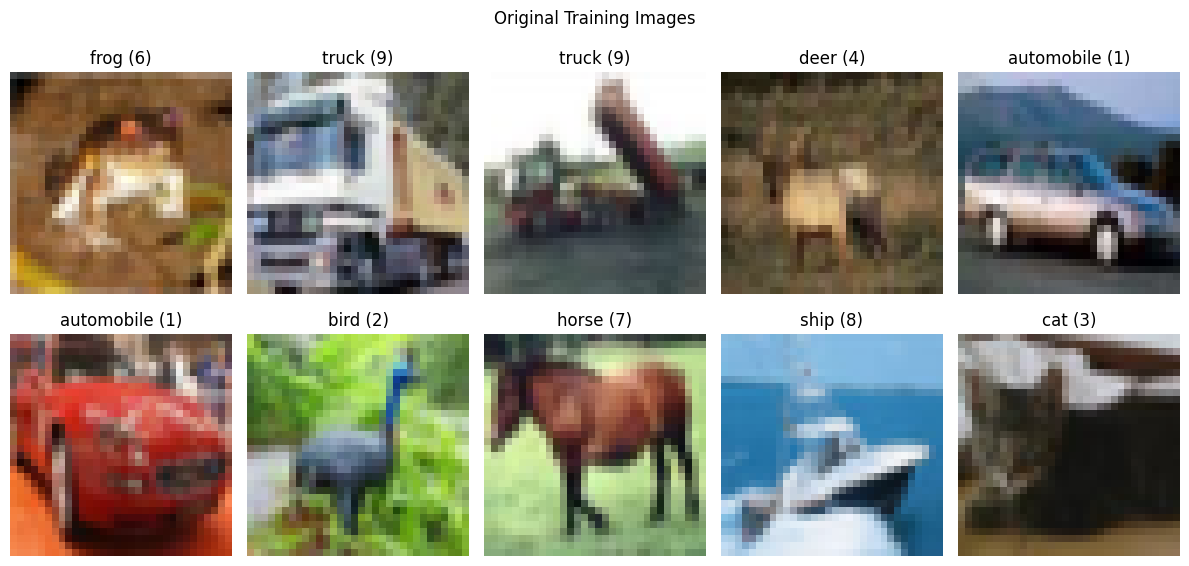

In [3]:
# %% [code]
# Enhanced Visualization
def plot_sample_images(images, labels, class_names, title="Sample Images"):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.title(f"{class_names[labels[i]]} ({labels[i]})")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_sample_images(x_train, y_train, class_names, "Original Training Images")


In [4]:
# %% [code]
# Improved Preprocessing
def preprocess_images(images, target_size=(64, 64), convert_to='gray'):
    """
    Enhanced preprocessing with multiple options
    """
    processed = []
    for img in images:
        if convert_to == 'gray':
            img_proc = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        elif convert_to == 'hsv':
            img_proc = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif convert_to == 'lab':
            img_proc = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        else:
            img_proc = img.copy()
            
        img_proc = cv2.resize(img_proc, target_size)
        processed.append(img_proc)
    
    return np.array(processed) / 255.0  # Normalize

In [5]:
# Process images in different color spaces
x_train_gray = preprocess_images(x_train, convert_to='gray')
x_test_gray = preprocess_images(x_test, convert_to='gray')


In [6]:
# %% [code]
# Feature Extraction Functions
def extract_hog_features(images, visualize=False):
    """
    Enhanced HOG feature extraction with options
    """
    if visualize:
        features, hog_images = zip(*[hog(img, pixels_per_cell=(16, 16), 
                                      cells_per_block=(2, 2), 
                                      visualize=True, channel_axis=None) 
                                   for img in images])
        return np.array(features), np.array(hog_images)
    else:
        features = [hog(img, pixels_per_cell=(16, 16), 
                   cells_per_block=(2, 2), 
                   channel_axis=None) 
                   for img in images]
        return np.array(features)

In [7]:
def extract_lbp_features(images):
    features = Parallel(n_jobs=-1)(
        delayed(lambda img: 
            np.histogram(
                local_binary_pattern((img * 255).astype(np.uint8),  # Convert to uint8
                P=16, R=2, method='uniform'),
                bins=np.arange(0, 16 + 3)
            )[0]
        )(img) for img in images
    )
    return np.array(features)

def extract_lbp_features(images, P=16, R=2, method='uniform'):
    """
    Enhanced LBP with more parameters
    """
    features = Parallel(n_jobs=-1)(
        delayed(lambda img: 
            np.histogram(
                local_binary_pattern(img, P=P, R=R, method=method),
                bins=np.arange(0, P + 3),
                range=(0, P + 2)
            )[0].astype("float") / 255.0
        )(img) for img in images
    )
    return np.array(features)

In [8]:
def extract_glcm_features(images, distances=[5], angles=[0], properties=['contrast', 'homogeneity']):
    """
    New GLCM feature extraction
    """
    features = []
    for img in (images * 255).astype(np.uint8):
        glcm = graycomatrix(img, distances=distances, angles=angles, symmetric=True, normed=True)
        feature = np.hstack([graycoprops(glcm, prop).ravel() for prop in properties])
        features.append(feature)
    return np.array(features)

In [9]:
def extract_sift_features(images, max_features=50):
    """
    New SIFT feature extraction
    """
    sift = cv2.SIFT_create()
    features = []
    for img in (images * 255).astype(np.uint8):
        _, desc = sift.detectAndCompute(img, None)
        if desc is not None:
            # Take first 'max_features' or pad if needed
            desc = desc[:max_features].flatten()
            if len(desc) < max_features * 128:
                desc = np.pad(desc, (0, max_features * 128 - len(desc)))
        else:
            desc = np.zeros(max_features * 128)
        features.append(desc)
    return np.array(features)

In [10]:
# %% [code]
# CNN Feature Extraction (using VGG16 instead of ResNet)
def extract_cnn_features(images):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    model = Model(inputs=base_model.input, outputs=base_model.output)
    
    # Preprocess for VGG
    processed = np.array([cv2.resize(img, (64, 64)) for img in images])
    processed = preprocess_input(processed)
    
    features = model.predict(processed, batch_size=32)
    return features.reshape(features.shape[0], -1)

In [11]:
# %% [code]
# Extract all features (with timing)
feature_sets = {}

print("Extracting HOG features...")
start = time.time()
x_train_hog, hog_images = extract_hog_features(x_train_gray, visualize=True)
x_test_hog = extract_hog_features(x_test_gray)
feature_sets['HOG'] = (x_train_hog, x_test_hog)
print(f"HOG features extracted in {time.time()-start:.2f} seconds")

Extracting HOG features...
HOG features extracted in 76.41 seconds


In [12]:
print("\nExtracting LBP features...")
start = time.time()
x_train_lbp = extract_lbp_features(x_train_gray)
x_test_lbp = extract_lbp_features(x_test_gray)
feature_sets['LBP'] = (x_train_lbp, x_test_lbp)
print(f"LBP features extracted in {time.time()-start:.2f} seconds")


Extracting LBP features...
LBP features extracted in 36.81 seconds


In [13]:
print("\nExtracting GLCM features...")
start = time.time()
x_train_glcm = extract_glcm_features(x_train_gray)
x_test_glcm = extract_glcm_features(x_test_gray)
feature_sets['GLCM'] = (x_train_glcm, x_test_glcm)
print(f"GLCM features extracted in {time.time()-start:.2f} seconds")


Extracting GLCM features...
GLCM features extracted in 40.93 seconds


In [14]:
print("\nExtracting SIFT features...")
start = time.time()
x_train_sift = extract_sift_features(x_train_gray)
x_test_sift = extract_sift_features(x_test_gray)
feature_sets['SIFT'] = (x_train_sift, x_test_sift)
print(f"SIFT features extracted in {time.time()-start:.2f} seconds")


Extracting SIFT features...
SIFT features extracted in 123.75 seconds


In [15]:
print("\nExtracting CNN features...")
start = time.time()
x_train_cnn = extract_cnn_features(x_train)
x_test_cnn = extract_cnn_features(x_test)
feature_sets['CNN'] = (x_train_cnn, x_test_cnn)
print(f"CNN features extracted in {time.time()-start:.2f} seconds")


Extracting CNN features...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 275s 175ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 170ms/step
CNN features extracted in 335.39 seconds


In [ ]:
def visualize_features(original, features, title):
    plt.figure(figsize=(15, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    # Feature Representation
    plt.subplot(1, 3, 2)
    if len(features.shape) == 2:  # 2D features (HOG image, CNN activations)
        plt.imshow(features, aspect='auto', cmap='viridis')
    elif len(features.shape) == 1:  # 1D features (LBP/GLCM histograms)
        plt.bar(range(len(features)), features)
        plt.xlabel("Feature Bins")
    else:  # Raw 2D features (SIFT keypoints)
        plt.imshow(features, cmap='gray')
    plt.title("Feature Representation")
    plt.axis('off')
    
    # Feature Distribution
    plt.subplot(1, 3, 3)
    plt.hist(features.flatten(), bins=50)
    plt.title("Feature Distribution")
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

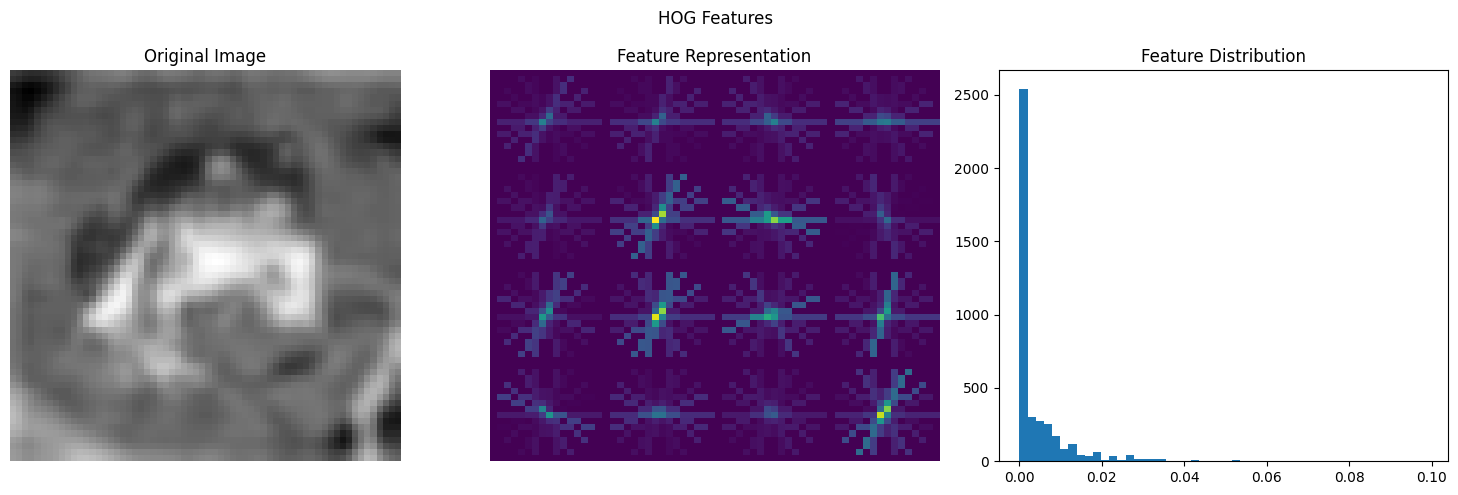

TypeError: Invalid shape (18,) for image data

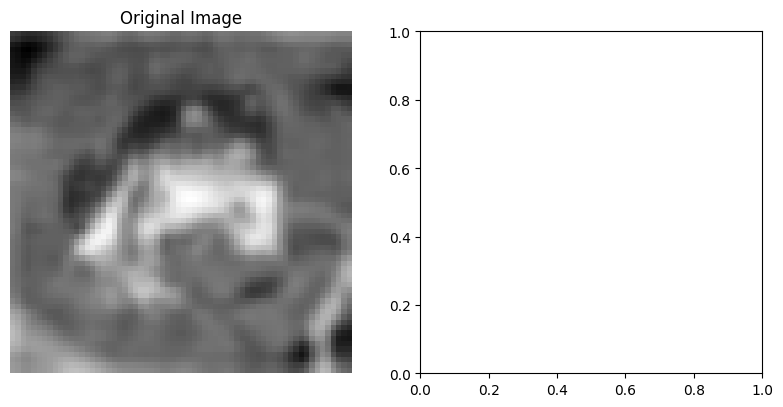

In [ ]:
# For HOG (2D features)
visualize_features(x_train_gray[0], hog_images[0], "HOG Features")

# For LBP (1D histogram)
visualize_features(x_train_gray[0], x_train_lbp[0], "LBP Features")

# For GLCM (1D vector)
visualize_features(x_train_gray[0], x_train_glcm[0], "GLCM Features")

# For SIFT (2D keypoints - if applicable)
visualize_features(x_train_gray[0], x_train_sift[0].reshape(64,64), "SIFT Features") 

In [19]:
# %% [code]
# Model Training and Evaluation
def train_and_evaluate(feature_name, x_train, x_test, model_type='svm'):
    print(f"\n{'='*50}")
    print(f"Training with {feature_name} features")
    
    if model_type == 'svm':
        model = SVC(kernel='rbf', C=10, gamma='scale')
    elif model_type == 'gbm':
        model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
    else:
        model = RandomForestClassifier(n_estimators=100)
    
    start = time.time()
    model.fit(x_train, y_train)
    train_time = time.time() - start
    
    start = time.time()
    y_pred = model.predict(x_test)
    pred_time = time.time() - start
    
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nResults for {feature_name} with {model.__class__.__name__}:")
    print(f"Training time: {train_time:.2f}s")
    print(f"Prediction time: {pred_time:.2f}s")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
     # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {feature_name} Features\n{model.__class__.__name__}')
    plt.show()
    
    return accuracy, train_time, pred_time


Training with HOG features

Results for HOG with SVC:
Training time: 617.68s
Prediction time: 85.78s
Accuracy: 0.6497

Classification Report:
              precision    recall  f1-score   support

    airplane       0.67      0.73      0.70      1000
  automobile       0.78      0.79      0.79      1000
        bird       0.54      0.54      0.54      1000
         cat       0.46      0.43      0.45      1000
        deer       0.57      0.61      0.59      1000
         dog       0.53      0.50      0.51      1000
        frog       0.72      0.72      0.72      1000
       horse       0.75      0.69      0.72      1000
        ship       0.72      0.71      0.71      1000
       truck       0.78      0.76      0.77      1000

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000



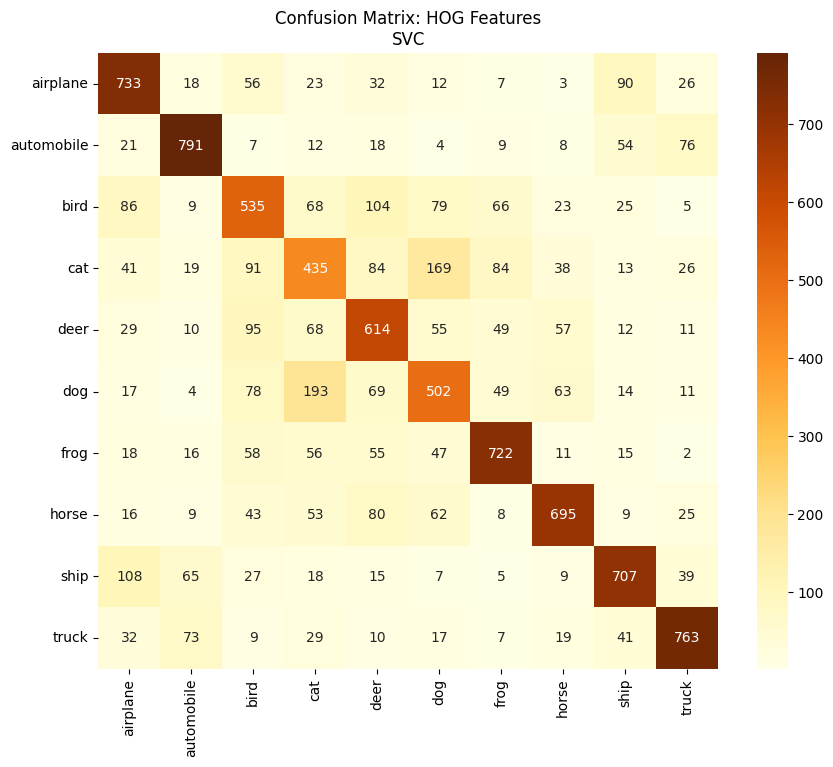


Training with LBP features

Results for LBP with GradientBoostingClassifier:
Training time: 962.89s
Prediction time: 0.13s
Accuracy: 0.3296

Classification Report:
              precision    recall  f1-score   support

    airplane       0.37      0.35      0.36      1000
  automobile       0.34      0.46      0.39      1000
        bird       0.23      0.08      0.12      1000
         cat       0.26      0.17      0.21      1000
        deer       0.36      0.42      0.39      1000
         dog       0.30      0.38      0.34      1000
        frog       0.45      0.50      0.47      1000
       horse       0.28      0.32      0.30      1000
        ship       0.30      0.28      0.28      1000
       truck       0.31      0.35      0.33      1000

    accuracy                           0.33     10000
   macro avg       0.32      0.33      0.32     10000
weighted avg       0.32      0.33      0.32     10000



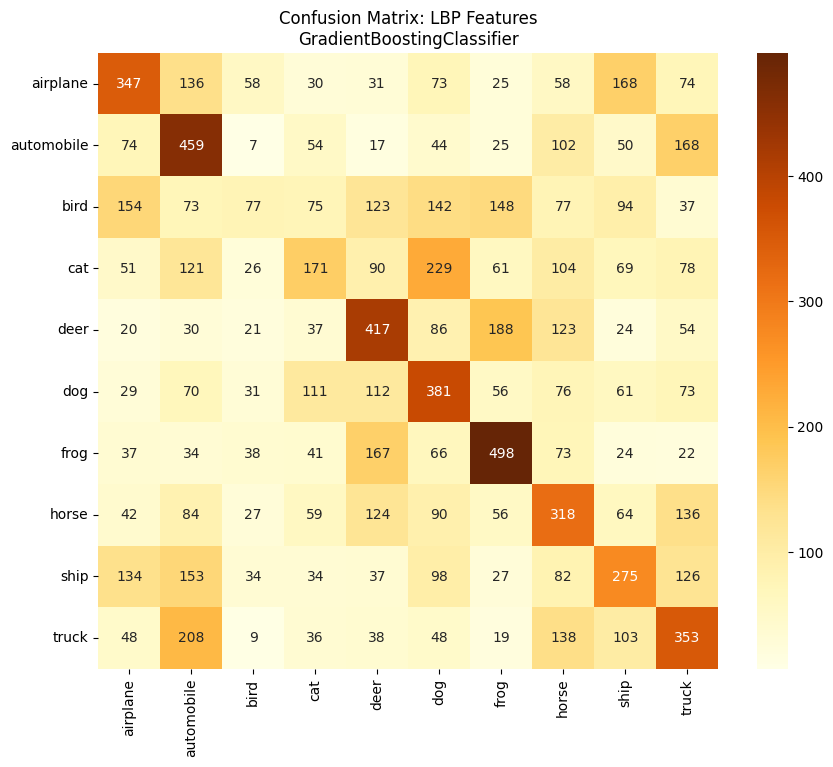


Training with GLCM features

Results for GLCM with GradientBoostingClassifier:
Training time: 45.13s
Prediction time: 0.08s
Accuracy: 0.2474

Classification Report:
              precision    recall  f1-score   support

    airplane       0.33      0.37      0.35      1000
  automobile       0.16      0.17      0.16      1000
        bird       0.21      0.01      0.01      1000
         cat       0.14      0.02      0.03      1000
        deer       0.28      0.38      0.32      1000
         dog       0.24      0.21      0.23      1000
        frog       0.31      0.42      0.35      1000
       horse       0.19      0.19      0.19      1000
        ship       0.28      0.44      0.34      1000
       truck       0.18      0.27      0.22      1000

    accuracy                           0.25     10000
   macro avg       0.23      0.25      0.22     10000
weighted avg       0.23      0.25      0.22     10000



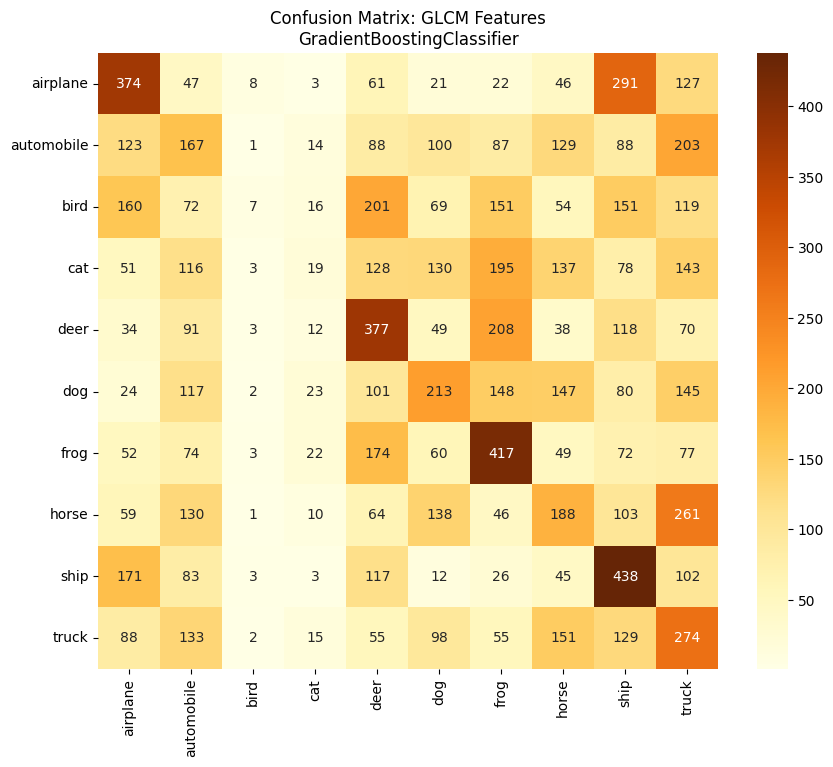


Training with SIFT features


: 

: 

In [24]:

# Evaluate all feature sets
results = []
for feature_name, (x_train_feat, x_test_feat) in feature_sets.items():
    # Use SVM for high-dim features, GBM for others
    model_type = 'svm' if feature_name in ['HOG', 'CNN', 'SIFT'] else 'gbm'
    acc, train_time, pred_time = train_and_evaluate(
        feature_name, x_train_feat, x_test_feat, model_type
    )
    results.append({
        'Feature': feature_name,
        'Model': 'SVM' if model_type == 'svm' else 'GBM',
        'Accuracy': acc,
        'Train Time': train_time,
        'Prediction Time': pred_time
    })

In [1]:
# Add these imports at the TOP of your notebook/script
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Your existing comparative analysis code
results_df = pd.DataFrame(results)
print("\nComparative Results:")
print(results_df)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Feature', y='Accuracy', data=results_df, palette='viridis')
plt.title('Accuracy Comparison')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='Feature', y='Train Time', data=results_df, palette='rocket')
plt.title('Training Time Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

NameError: name 'results' is not defined

In [2]:
# %% [code]
# Feature Importance Analysis (for tree-based models)
def plot_feature_importance(model, feature_name):
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        importances = model.feature_importances_
        plt.bar(range(len(importances)), importances)
        plt.title(f'Feature Importance - {feature_name}')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        plt.show()

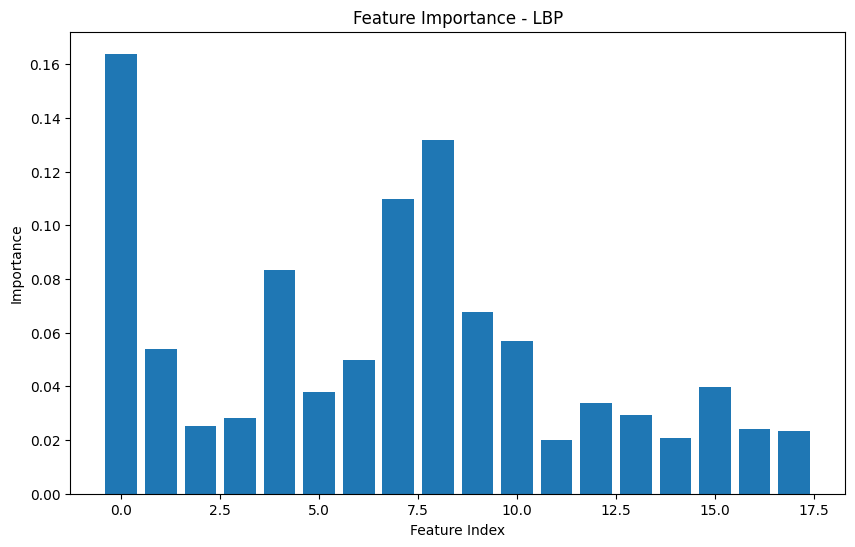

In [23]:
# Plot for one of the models
plot_feature_importance(GradientBoostingClassifier().fit(x_train_lbp, y_train), 'LBP')